## Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn
### Итоговый проект

Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [449]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Пути к расположению файлов

In [451]:
TRAIN_DATASET_PATH = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTS0EcAO3rOHMyl83ZimEuhWtMDNauoBVXA2wHN1MzIC4S-LfytuyozTvTe6TO-pYEAzbBByQysekJX/pub?output=csv'
TEST_DATASET_PATH = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRAycneQB841XwMtOtNLIkUlqaahCvReAQL4eHYKM9h_rc0DjefHE9L4YjXogJWPbhuUEqT90dNIWE7/pub?output=csv'
SAMPLE_SUB_PATH = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQPWPnvaWlkfjbLVaJXGEmhRryZwuAjle_etuBYdr1wp6Su8_hFRQZSNeUj4hfMY04a-fxH5OB36MHm/pub?output=csv'

### 1. Подготовка данных

Сперва посмотрим на значения в датасете: выведим хранимую там инфомрацию и ее описание

In [452]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head(7)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272


Для наглядности также смотрим описание данных

In [398]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


В данном случае нас пока интересуют такие показатели, как min и max. В колонке 'Rooms' минимальное значение равно 0, максимальное - 19. В данной работе кол-во комнат, равное 0, считается за квартиру-студию, поэтому из датасета не убирается. То же самое относится к нулевому значению у параметра 'KitchenSquare'. Тем не менее в датасете на некоторых позиция отсутствуют значения - NaN. 

Прежде, чем обрабатывать дальше данные, посмотрим, какие в принципе есть типы данных в датасете.

In [309]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Чтобы было легче обращаться с данными, в будущем следует изменить типы object на бинарные.

Пока решим первую задачу - избавимся от пропусков в датасете.

In [450]:
train_df_num = train_df.select_dtypes(include={'float64', 'int64'})
train_df_num.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,11,3097,0,900.0,0,0,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.720850
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,1,264,0,900.0,0,1,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,900.0,0,6,343995.102962


In [9]:
train_df_obj = train_df.select_dtypes(include={'object'})
train_df_obj.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


Посмотрим, есть ли в датасете пропуски:

In [11]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Как видно из значений выше, пропуски есть у параметров 'LifeSquare' и 'Healthcare_1'. Начнем заполнять их медианными значениями.

In [453]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

Убедимся, что больше пропусков нет:

In [419]:
len(train_df) - train_df.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

Теперь надо убрать значения NaN:

In [454]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()
train_df.loc[train_df['Square'].isnull(), 'Square'] = train_df['Square'].median()

train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,900.0,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,900.0,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,900.0,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,900.0,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


Посмотрим на корректность данных. Начнем с параметров 'LifeSquare' и 'Square'. По определению, жилплощадь не может быть больше общей площади недвижимости. Проверим:

In [455]:
train_df[train_df['LifeSquare'] >= train_df['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
33,847,74,2.0,73.314975,74.131261,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,254005.381863
64,3992,1,3.0,87.200625,87.730225,0.0,21,22.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,300180.365669
77,11771,45,1.0,38.467276,39.624493,1.0,11,9.0,1977,0.195781,B,B,23,5212,6,900.0,3,2,B,247440.530601
100,13343,74,2.0,79.937665,82.931595,1.0,8,21.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,226808.747168
111,13875,20,1.0,28.438794,32.514021,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.114376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,900.0,1,10,B,524365.550705
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617
9979,2201,6,1.0,40.043234,41.984322,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,900.0,0,1,B,203908.192698


Скорее всего, показатели были перепутаны местами. Исправим это следующим способом:

In [456]:
train_df_valid = train_df.copy()

In [457]:
train_df.loc[train_df['LifeSquare'] > train_df['Square'], 'LifeSquare'] = train_df_valid['Square']
train_df.loc[train_df['LifeSquare'] >= train_df['Square'], 'Square'] = train_df_valid['LifeSquare']

train_df[train_df['LifeSquare'] >= train_df['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Изменим тип переменных на булев:

In [458]:
train_df_bool = pd.get_dummies(train_df, columns=['Ecology_2', 'Ecology_3', 'Shops_2'])              
train_df_bool.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

Проверим также и год постройки дома:

In [459]:
train_df_bool[train_df_bool['HouseYear'] >= 2050]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
8828,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,...,2857.0,5,8,243028.603096,0,1,0,1,0,1
9163,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,...,262.0,3,6,254084.534396,0,1,0,1,0,1


Здесь присутствует ошибка в данных, поэтому их следует удалить из датасета:

In [460]:
train_df_bool = train_df_bool.loc[train_df_bool['HouseYear'] <= 2050]
train_df_bool

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,900.0,0,0,305018.871089,0,1,0,1,0,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,177734.553407,0,1,0,1,0,1
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,282078.720850,0,1,0,1,0,1
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,...,900.0,0,1,168106.007630,0,1,0,1,0,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,900.0,0,6,343995.102962,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,900.0,1,9,119367.455796,0,1,0,1,0,1
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,...,900.0,0,0,199715.148807,0,1,0,1,1,0
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,900.0,1,5,165953.912580,0,1,0,1,0,1
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,125.0,3,5,171842.411855,0,1,0,1,0,1


Минимальный размер квартиры - 6 кв.м (существующие на сегодняшний день). Исходя из этой информации посмотрим датасет на наличие меньшего метража

In [427]:
train_df_bool.loc[train_df_bool['LifeSquare'] < 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
26,8553,88,3.0,83.262530,4.769174,1.0,13,1.0,1977,0.127376,...,900.0,3,9,410883.892020,0,1,0,1,0,1
119,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,...,540.0,0,0,174741.998061,0,1,0,1,0,1
161,6782,45,1.0,5.257278,2.954309,1.0,3,1.0,1977,0.195781,...,900.0,3,2,438005.182323,0,1,0,1,0,1
212,1182,27,1.0,38.936986,3.064320,0.0,18,19.0,2017,0.211401,...,900.0,0,1,93560.789553,0,1,0,1,0,1
227,3746,62,1.0,46.722042,1.944446,1.0,11,12.0,2018,0.072158,...,900.0,0,0,133721.121715,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9462,10079,59,1.0,48.232741,3.288779,1.0,15,17.0,2017,0.019509,...,176.0,5,5,207086.637307,0,1,0,1,0,1
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,...,900.0,0,0,126596.941798,0,1,0,1,0,1
9912,13523,23,1.0,52.787090,5.600609,1.0,7,1.0,2015,0.014073,...,900.0,0,0,104160.492175,0,1,0,1,0,1
9938,2913,34,4.0,94.888593,2.637095,1.0,4,1.0,2018,0.069753,...,900.0,1,11,346949.506507,0,1,0,1,0,1


Удалим эти значения, так как они не соответствуют тому, что ищем:

In [461]:
train_df_bool = train_df_bool.loc[train_df_bool['LifeSquare'] >= 6]
train_df_bool.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,900.0,0,0,305018.871089,0,1,0,1,0,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,177734.553407,0,1,0,1,0,1
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,282078.720850,0,1,0,1,0,1
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,...,900.0,0,1,168106.007630,0,1,0,1,0,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,900.0,0,6,343995.102962,0,1,0,1,0,1


In [463]:
train_df_bool['Id'] = train_df_bool['Id'].astype(str)
train_df_bool['DistrictId'] = train_df_bool['DistrictId'].astype(str)

train_df_bool.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price',
       'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
       'Shops_2_B'],
      dtype='object')

In [464]:
train_df_bool.to_csv('C:/Users/User/Desktop/prepared_dataset_2', index=False, encoding='utf-8')

### 2. Обзор данных

In [465]:
PREPARED_DATASET = 'C:/Users/User/Desktop/prepared_dataset_2'

In [466]:
df = pd.read_csv(PREPARED_DATASET)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,900.0,0,0,305018.871089,0,1,0,1,0,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,177734.553407,0,1,0,1,0,1
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,282078.720850,0,1,0,1,0,1
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,...,900.0,0,1,168106.007630,0,1,0,1,0,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,900.0,0,6,343995.102962,0,1,0,1,0,1


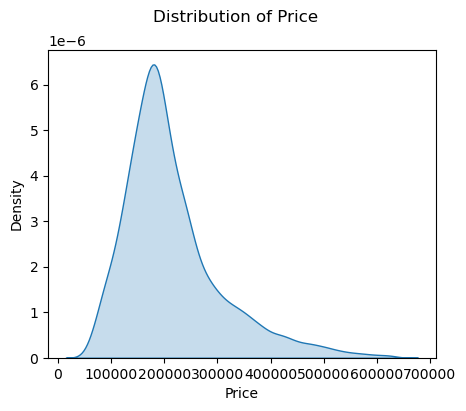

In [467]:
plt.figure(figsize = (5, 4))

plt.plot()
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [468]:
target_mean = round(df['Price'].mean(), 2)
target_median = round(df['Price'].median(), 2)
target_mode = round(df['Price'].mode()[0], 2)

target_mean, target_median, target_mode

(214431.57, 192744.32, 59174.78)

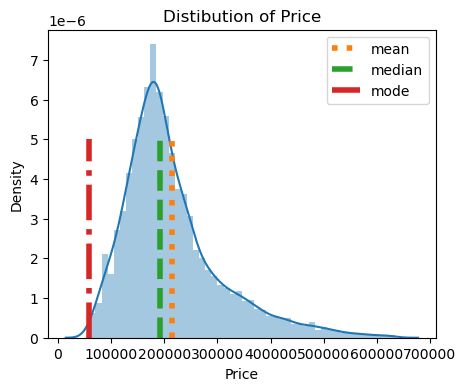

In [469]:
plt.figure(figsize = (5, 4))

sns.distplot(df['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distibution of Price')
plt.legend()
plt.show()

In [470]:
train_df_bool.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

### 3. Создание модели

In [471]:
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

target_name = 'Price'

In [472]:
X = train_df_bool[feature_names]
y = train_df_bool[target_name]

In [473]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

In [474]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Train R2: 0.962
Test R2: 0.706


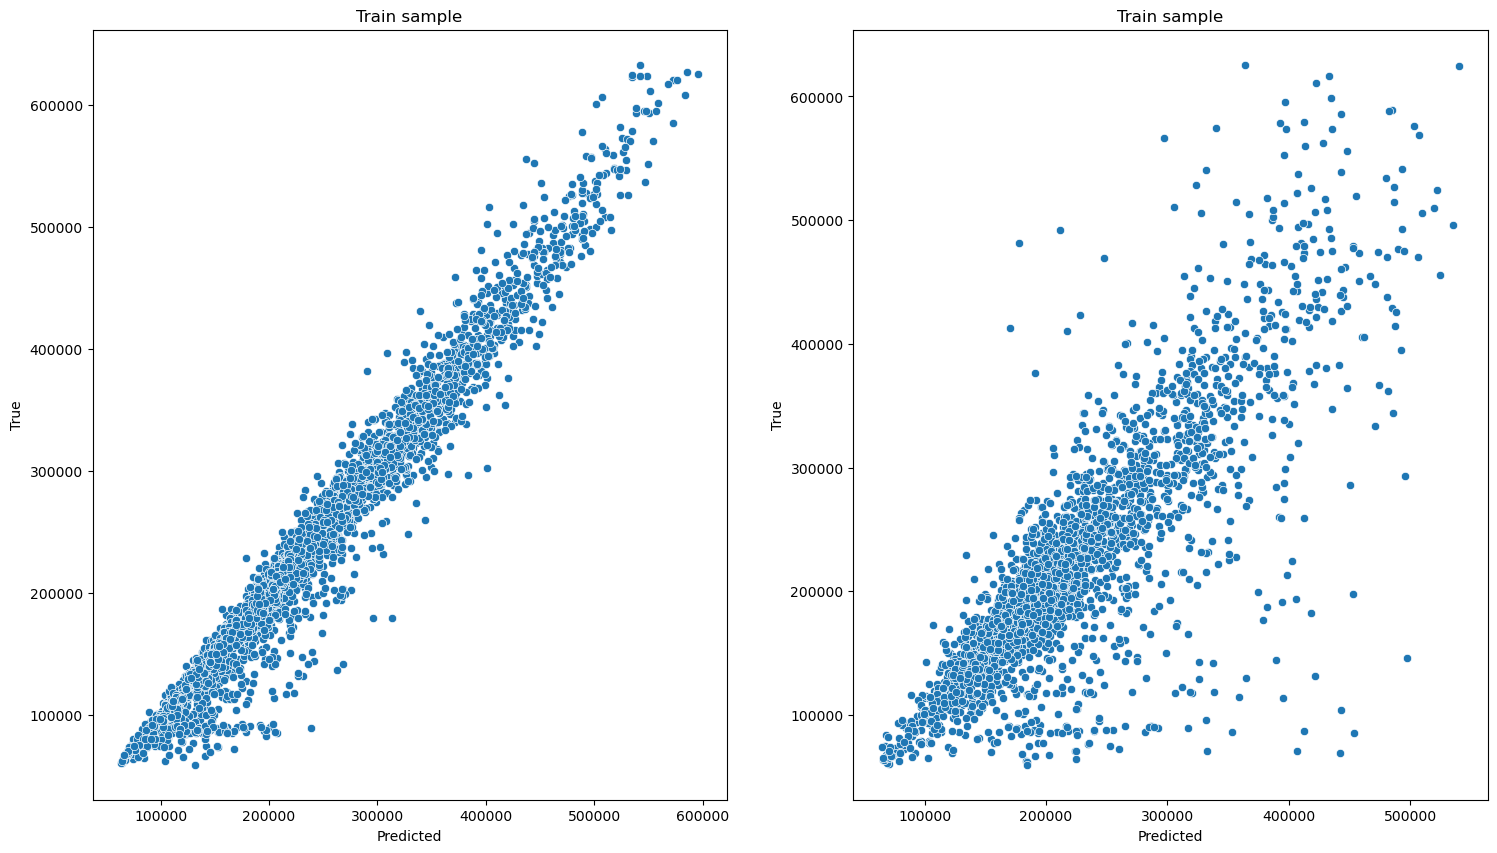

In [477]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [476]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True))

In [478]:
feature_importance = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_),
                                 columns=['feature_names', 'importance'])

feature_importance.sort_values(by='importance', ascending=False)

,feature_names,importance
2,Square,0.385948
10,Social_2,0.098406
9,Social_1,0.095724
1,Rooms,0.078274
11,Social_3,0.058614
8,Ecology_1,0.042848
0,DistrictId,0.040756
3,LifeSquare,0.035922
7,HouseYear,0.034953
5,Floor,0.028618


Больше всего на модель повлияла общая площадь недвижимости